In [2]:
import torch
import argparse
import time
from model import KDS

from tqdm import tqdm as progress_bar
import pickle
from torch import nn
import utils
from sklearn.cluster import k_means
from sklearn.manifold import spectral_embedding
import numpy as np
from utilities.MNISTutils import MNISTtoHistograms
from utilities.cost import gridCost
from wdl.bregman import barycenter, OT
from utilities.simpleDistributions import vec2grid, \
    sampleBaryFromDict, matchAtoms

import matplotlib.pyplot as plt

Load digits

In [7]:
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")

if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
#### pick mnist samples
height, width = 28, 28
n_atoms_per_digit = 3
digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
n_digits = len(digits)

"""
D, _ = MNISTtoHistograms('../../data', digits=digits, samples_per_digit=n_atoms_per_digit,
                         height=height,
                         width=width)
"""

# load original true dictionary used in experiment in paper
with open(
        "MNISTdata.pkl",
        'rb') as f:
    data = pickle.load(f)

D = data["True D"]

#### form barycenters data
maxsinkiters = 50
reg = 0.003
barySolver = barycenter(None, "conv", reg=reg, height=height, width=width, maxsinkiter=maxsinkiters)

# make tensor to store generated digits
n_samples = 50

X = torch.zeros((height * width), n_samples * n_digits, device=dev)
Lambda = torch.zeros((n_atoms_per_digit * n_digits, n_samples * n_digits), device=dev)

# generate digits as barycenters of the atoms
for i in range(len(digits)):
    X[:, i * n_samples:(i + 1) * n_samples], Lambda[i * n_atoms_per_digit:(i + 1) * n_atoms_per_digit,
                                             i * n_samples:(i + 1) * n_samples] = sampleBaryFromDict(
        D[:, i * n_atoms_per_digit:(i + 1) * n_atoms_per_digit], n_samples, barySolver)

In [8]:
localities = [0.0, 0.001, 0.1, 10]
k = 30

data = X.mT
epochs = 30

batch_size = 1024
lr = 1e-3

Ds = []
# train kds
for mu in localities:
    hyp = {
        "num_layers": 100,
        "input_size": X.shape[0],
        "hidden_size": k,
        "penalty": mu,
        "train_step": False,
    }

    net = KDS(**hyp)
    with torch.no_grad():
        p = torch.randperm(len(data))[: net.hidden_size]
        net.W.data = data[p]
        net.step.fill_((net.W.data.svd()[1][0] ** -2).item())
    net = net.to(dev)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = utils.LocalDictionaryLoss(hyp["penalty"])
    net.train()
    for epoch in progress_bar(range(epochs)):
        shuffle = torch.randperm(len(data))
        train_data = data[shuffle]
        for i in progress_bar(range(0, len(data), batch_size), disable=True):
            y = train_data[i: i + batch_size].to(dev)
            x_hat = net.encode(y)
            loss = criterion(net.W, y, x_hat)
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), 1e-4)
            optimizer.step()

    Ds.append(net.W.data.mT.detach().clone())

100%|██████████| 30/30 [00:05<00:00,  5.29it/s]


In [9]:
# match atoms
from scipy.optimize import linear_sum_assignment


def matchAtoms(D1, D2, weights=None):
    """
    aligns set of distributions D1 to D2 by finding the minimum assignment when comparing the distributions via OT

    :param D1: set of distributions
    :param D2: set of distributions to be aligned to
    :param OTsolver: function that takes two distributions as arguments
    :return:
    """
    assert (D1.shape == D2.shape)

    k = D1.shape[1]
    C = torch.zeros((k, k))
    for i in range(k):
        for j in range(k):
            C[i, j] = torch.linalg.norm(D1[:, i] - D2[:, j])

    old_assignments, assignments = linear_sum_assignment(C)
    cost = C[old_assignments, assignments].sum()

    D1[:, assignments] = D1[:, old_assignments]

    if weights is not None:
        weights[assignments, :] = weights[old_assignments, :]

        return D1, weights, cost
    else:
        return D1, cost


matchedDs = []
for i in range(len(localities)):
    Dmatched, _ = matchAtoms(Ds[i], D)
    matchedDs.append(Dmatched)


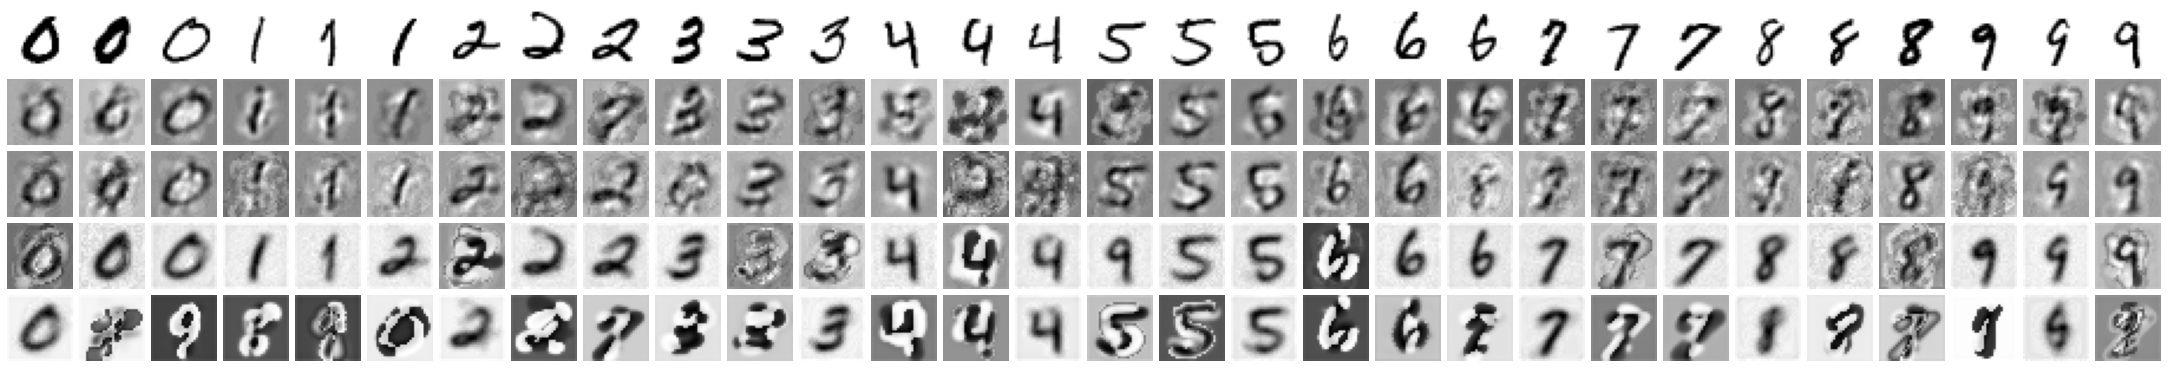

In [10]:
n_plots = len(localities)
fig, ax = plt.subplots((n_plots + 1), 30, figsize=(30, (n_plots + 1) * 1), constrained_layout=True,
                       gridspec_kw={'wspace': 0, 'hspace': 0})

for j in range(30):
    ax[0, j].imshow(D[:, j].view(28, 28), cmap="gray_r")
    ax[0, j].axis("off")

for i in range(n_plots):
    for j in range(30):
        ax[i + 1, j].imshow(matchedDs[i][:, j].view(28, 28), cmap="gray_r")
        ax[i + 1, j].axis("off")

#fig.tight_layout()
# fig.savefig("KDSmnist.pdf")

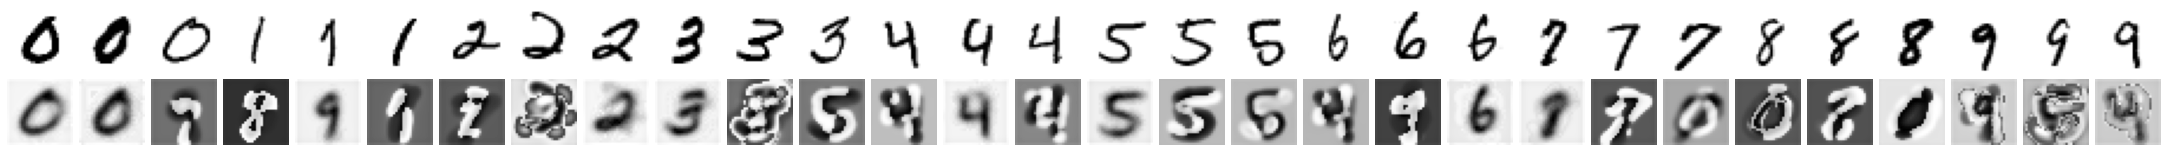

In [30]:
n_plots = 1
fig, ax = plt.subplots((n_plots + 1), 30, figsize=(30, (n_plots + 1) * 1), constrained_layout=True,
                       gridspec_kw={'wspace': 0, 'hspace': 0})

for j in range(30):
    ax[0, j].imshow(D[:, j].view(28, 28), cmap="gray_r")
    ax[0, j].axis("off")

for j in range(30):
    ax[1, j].imshow(matchedDs[i][:, j].view(28, 28), cmap="gray_r")
    ax[1, j].axis("off")

#fig.tight_layout()
fig.savefig("KDSmnist1Line.pdf")